In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from identification import *

plt.style.use('default')

# Validação dos modelos

In [22]:
def number_of_zeros(x):
    for i in range(x.size):
        if x[i] != 0:
            return i
    return 0

In [23]:
df_data_n11 = pd.read_csv('../data/entrada_saida_nsenos_n11_111v.csv', header=None)

df_theta_hat_2o = pd.read_csv('../data/theta_hat_2o_emax_111.csv', header=None)
df_theta_hat_ed = pd.read_csv('../data/theta_hat_ed_emax_111.csv', header=None)

In [24]:
data_n11  = np.array(df_data_n11    , ndmin=2)
u_ar_n11  = np.array(df_data_n11[0] , ndmin=2).T
y_ar_n11  = np.array(df_data_n11[1] , ndmin=2).T

theta_hat_2o = np.array(df_theta_hat_2o, ndmin=2)
theta_hat_ed = np.array(df_theta_hat_ed, ndmin=2)

In [25]:
nz = number_of_zeros(y_ar_n11)
y_ar_n11 = y_ar_n11[nz-1:]
u_ar_n11 = u_ar_n11[nz-1:]

In [26]:
u_ar_n11.size

1199

In [27]:
print(y_ar_n11[:2].T)

[[  0.         151.36558196]]


In [28]:
y_hat_2o_n11 =    estimate_output(y=y_ar_n11, u=u_ar_n11, theta=theta_hat_2o, ord=2)
y_hat_ed_n11 = estimate_output_ed(y=y_ar_n11 ,u=u_ar_n11 ,theta=theta_hat_ed)

In [29]:
T1 = 0
T2 = -1

V_2o = cost_func(y_ar_n11[T1:T2], y_hat_2o_n11[T1:T2])
V_ed = cost_func(y_ar_n11[T1:T2], y_hat_ed_n11[T1:T2])


print('Resultados validação n=11:')

print(f'ARX 2ª ordem V = {V_2o}')
print(f'discretizado V = {V_ed}')

Resultados validação n=11:
ARX 2ª ordem V = 4377.360720434349
discretizado V = 1797.1948662323043


# Análise dos resíduos

In [30]:
# e_t = y_t - y_hat_t
e_2o_n11 = y_ar_n11 - y_hat_2o_n11
e_ed_n11 = y_ar_n11 - y_hat_ed_n11

In [31]:
df = pd.DataFrame(e_2o_n11)
df.to_csv('../data/e_2o_n11_d.csv',header=False,index=False)
df = pd.DataFrame(e_ed_n11)
df.to_csv('../data/e_ed_n11_d.csv',header=False,index=False)

In [32]:
# função de covariança como mostrada no livro
def prev_cov(e,u):
    Tau = np.arange(u.size)
    R = np.zeros(u.shape)
    for tau in Tau:
        N = np.arange(tau,u.size)
        for t in N:
            R[tau] += (e[t] * u[t-tau])
    return R / u.size

In [33]:
T1 = 0

R_eu_2o = prev_cov(e_2o_n11[T1:],u_ar_n11[T1:])
R_eu_ed = prev_cov(e_ed_n11[T1:],u_ar_n11[T1:])

R_e_2o = prev_cov(e_2o_n11[T1:],e_2o_n11[T1:])
R_e_ed = prev_cov(e_ed_n11[T1:],e_ed_n11[T1:])
                        
R_u_2o = prev_cov(u_ar_n11[T1:],u_ar_n11[T1:])
R_u_ed = prev_cov(u_ar_n11[T1:],u_ar_n11[T1:])

In [34]:
P1_2o = np.sum(R_e_2o*R_u_2o)
P1_ed = np.sum(R_e_ed*R_u_ed)

N_alfa = 1.65 # alfa = 0.1

In [35]:
lim_2o = np.sqrt(P1_2o/e_2o_n11.size)*(N_alfa)
lim_ed  = np.sqrt(P1_ed/e_ed_n11.size)*(N_alfa)

print(f'sqrt(P1/N)*N_alfa _2o  = {lim_2o}')
print(f'sqrt(P1/N)*N_alfa _ed  = {lim_ed}')

sqrt(P1/N)*N_alfa _2o  = 132.3439559433993
sqrt(P1/N)*N_alfa _ed  = 42.62488137931747


Arrumar essa imagem

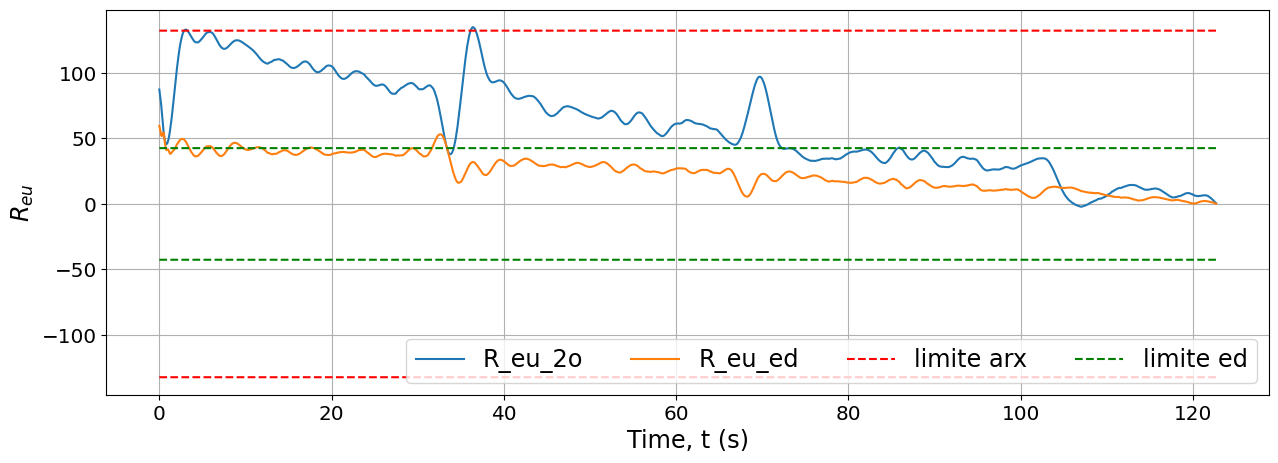

In [38]:
t = np.arange(0,R_e_2o.size)*0.1024

lim_sup_2o = np.ones(R_eu_2o.shape)*lim_2o
lim_sup_ed = np.ones(R_eu_ed.shape)*lim_ed
plt.figure(1,figsize=[15,5])
plt.grid(True)

#plt.ylim([-150,150])
#plt.xlim([-5,125])
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')

plt.xlabel('Time, t (s)',fontsize='xx-large')
plt.ylabel("$R_{eu}$",fontsize='xx-large')

plt.plot(t,R_eu_2o,label='R_eu_2o')
plt.plot(t,R_eu_ed,label='R_eu_ed')
plt.plot(t, lim_sup_2o,'--',color='red',label='limite arx')
plt.plot(t,-lim_sup_2o,'--',color='red')
plt.plot(t, lim_sup_ed,'--',color='green',label='limite ed')
plt.plot(t,-lim_sup_ed,'--',color='green')
plt.legend(fontsize='xx-large', ncol=4,loc='lower right')

plt.savefig(fname='../figures/R_eu.png')